In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# read in the data
dataset = pd.read_csv('prepared_gasoline.csv')

# read in the geo data
geo = pd.read_csv('latlongeo.csv')
geo.drop(['Unnamed: 0', 'region'], axis=1, inplace=True)

# join them -- inner drops the lat/lon nan values
dataset = dataset.merge(geo, how='inner', on=['latitude', 'longitude'])

# add global mean of gas price for each observation
global_mean = dataset.groupby('date')['e5gas'].mean()
global_df = global_mean.to_frame()
global_df.rename(columns={"e5gas": "global_mean"}, inplace=True)
dataset = dataset.merge(global_df, right_index=True, left_on='date')

# add regional mean of gas price for each observation
state_mean = dataset.groupby(['date', 'state'])['e5gas'].mean()
state_df = state_mean.to_frame()
state_df.rename(columns={"e5gas": "state_mean"}, inplace=True)
dataset = dataset.merge(state_df, right_index=True, left_on=['date', 'state'])

# one hot encode state and marke
dataset['state'] = pd.Categorical(dataset['state']).codes

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# run individual time series on station 1 and 2
# combine them into one values and run it again, predicting separately for 1 and 2 and compare
station_indices = dataset['station'].value_counts() == 575
full_series = pd.DataFrame()
full_series['T/F'] = station_indices[station_indices]
full_series['index'] = full_series.index
dataset_fullseries = dataset[dataset['station'].isin(full_series['index'])]

In [3]:
df = dataset_fullseries.copy()

In [4]:
# include variable that is number of days since sample started
df['date'] = pd.to_datetime(df['date'])
start = pd.to_datetime('2014-05-16')
df['num_days'] = df.apply(lambda row: (row['date'] - start).days, axis=1)

# set date as index
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['e5gas'].fillna(0, inplace=True)
cols = list(df)
cols.insert(0, cols.pop(cols.index('e5gas')))
df = df.loc[:, cols]

df.head()

,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.573706,5,52.317699,9.96611,5539.611816,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,6873.0,13,14565,1.546131,1.530105,0
2014-05-16,1.550250,5,51.089699,6.58208,1211.936890,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,7828.0,15,6071,1.546131,1.541350,0
2014-05-16,1.546222,5,51.675098,7.78013,6230.800781,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,7887.0,15,8793,1.546131,1.541350,0
2014-05-16,1.520765,5,51.194801,6.50602,3022.041504,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,12115.0,15,5991,1.546131,1.541350,0
2014-05-16,1.533444,5,51.557400,7.68249,1240.194946,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,31437.0,15,8595,1.546131,1.541350,0


In [5]:
# put in order to be made into supervised problem
df.sort_values(by=['station', 'num_days'], inplace=True)
df.head()

,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [ ]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_lag = 1
n_seq = 30
reframed = series_to_supervised(scaled, n_lag, n_seq)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]], axis=1, inplace=True)
reframed.head()

In [18]:
# reframed['var21(t-1)'].mean()

0.5000001788139343

In [19]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# var21(t-1) is num_days
# var18(t-1) is station
n = 7316300
# reframed.sort_values(by=['var21(t-1)', 'var18(t-1)'], inplace=True)
values = reframed.values
n_train_days = int(n*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5853040, 1, 21) (5853040,) (1463259, 1, 21) (1463259,)


Train on 5853040 samples, validate on 1463259 samples
Epoch 1/10
 - 35s - loss: 0.0265 - val_loss: 0.0214
Epoch 2/10
 - 36s - loss: 0.0128 - val_loss: 0.0165
Epoch 3/10
 - 38s - loss: 0.0108 - val_loss: 0.0120
Epoch 4/10
 - 38s - loss: 0.0086 - val_loss: 0.0070
Epoch 5/10
 - 36s - loss: 0.0062 - val_loss: 0.0060
Epoch 6/10
 - 41s - loss: 0.0049 - val_loss: 0.0051
Epoch 7/10
 - 44s - loss: 0.0047 - val_loss: 0.0051
Epoch 8/10
 - 37s - loss: 0.0047 - val_loss: 0.0050
Epoch 9/10
 - 36s - loss: 0.0045 - val_loss: 0.0045
Epoch 10/10
 - 34s - loss: 0.0047 - val_loss: 0.0051


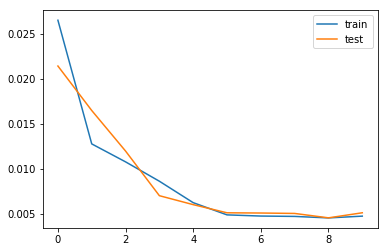

In [20]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(30))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.026
